In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

## Model Architecture

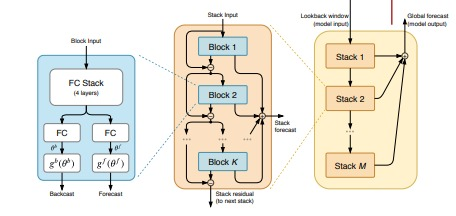

## NBeats Block

In [2]:

class NBeatsBlock(tf.keras.layers.Layer):
  def __init__(self, input_size: int, theta_size: int, horizon: int, n_neurons: int, n_layers: int, **kwargs):
    super().__init__(**kwargs)
    self.input_size = input_size
    self.theta_size = theta_size
    self.horizon = horizon
    self.n_neurons = n_neurons
    self.n_layers = n_layers

    self.hidden = [tf.keras.layers.Dense(n_neurons, activation="relu") for _ in range(n_layers)]

    self.theta_layer = tf.keras.layers.Dense(theta_size, activation="linear", name="theta")

  def call(self, inputs):
    x = inputs
    for layer in self.hidden:
      x = layer(x)
    theta = self.theta_layer(x)
    backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
    return backcast, forecast

In [26]:
data = pd.read_csv('/content/time_series.csv')
data

,people
0,176
1,351
2,101
3,386
4,199
...,...
351,597
352,291
353,198
354,439


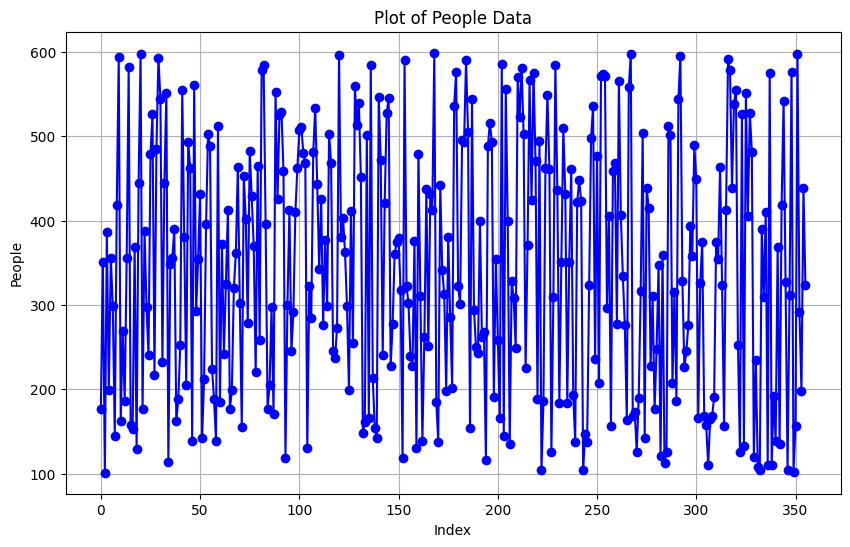

In [28]:
plt.figure(figsize=(10, 6))
plt.plot(data.index, data['people'], color='blue', marker='o', linestyle='-')
plt.title('Plot of People Data')
plt.xlabel('Index')
plt.ylabel('People')
plt.grid(True)
plt.show()

In [27]:
data.describe()

,people
count,356.000000
mean,344.497191
std,148.962827
min,101.000000
25%,204.250000
50%,349.500000
75%,471.250000
max,599.000000


In [30]:
HORIZON = 1
WINDOW_SIZE = 7

In [31]:
data_nbeats = data.copy()
for i in range(WINDOW_SIZE):
  data_nbeats[f"people{i+1}"] = data_nbeats["people"].shift(periods=i+1)
data_nbeats.dropna().head()

,people,people1,people2,people3,people4,people5,people6,people7
7,144,299.0,356.0,199.0,386.0,101.0,351.0,176.0
8,418,144.0,299.0,356.0,199.0,386.0,101.0,351.0
9,594,418.0,144.0,299.0,356.0,199.0,386.0,101.0
10,162,594.0,418.0,144.0,299.0,356.0,199.0,386.0
11,269,162.0,594.0,418.0,144.0,299.0,356.0,199.0


In [32]:
X = data_nbeats.dropna().drop("people", axis=1)
y = data_nbeats.dropna()["people"]



split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(279, 279, 70, 70)

## Preparing data

In [33]:

train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

BATCH_SIZE = 1024
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

In [34]:

N_EPOCHS = 5000
N_NEURONS = 512
N_LAYERS = 4
N_STACKS = 30

INPUT_SIZE = WINDOW_SIZE * HORIZON
THETA_SIZE = INPUT_SIZE + HORIZON

INPUT_SIZE, THETA_SIZE

(7, 8)

## Clubbing all blocks and stacks and making the final model

In [35]:
from tensorflow.keras import layers
tf.random.set_seed(42)

nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE,
                                 theta_size=THETA_SIZE,
                                 horizon=HORIZON,
                                 n_neurons=N_NEURONS,
                                 n_layers=N_LAYERS)

stack_input = layers.Input(shape=(INPUT_SIZE))
backcast, forecast = nbeats_block_layer(stack_input)
residuals = layers.subtract([stack_input, backcast])

for i, _ in enumerate(range(N_STACKS-1)):
  backcast, block_forecast = NBeatsBlock(
      input_size=INPUT_SIZE,
      theta_size=THETA_SIZE,
      horizon=HORIZON,
      n_neurons=N_NEURONS,
      n_layers=N_LAYERS
  )(residuals)

  residuals = layers.subtract([residuals, backcast])
  forecast = layers.add([forecast, block_forecast])

model = tf.keras.Model(inputs=stack_input,
                         outputs=forecast)


model.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae", "mse"])

model.fit(train_dataset,
            epochs=N_EPOCHS,
            validation_data=test_dataset,
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=200, restore_best_weights=True),
                      tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=100, verbose=1)])

Epoch 1/5000
1/1 [==============================] - 49s 49s/step - loss: 414.5550 - mae: 414.5550 - mse: 194887.8281 - val_loss: 5943.8936 - val_mae: 5943.8936 - val_mse: 36765672.0000 - lr: 0.0010
Epoch 2/5000
1/1 [==============================] - 0s 222ms/step - loss: 6433.8887 - mae: 6433.8887 - mse: 42304272.0000 - val_loss: 2155.9094 - val_mae: 2155.9094 - val_mse: 4899049.0000 - lr: 0.0010
Epoch 3/5000
1/1 [==============================] - 0s 254ms/step - loss: 2056.7559 - mae: 2056.7559 - mse: 4375949.0000 - val_loss: 754.6230 - val_mae: 754.6230 - val_mse: 631729.6250 - lr: 0.0010
Epoch 4/5000
1/1 [==============================] - 0s 215ms/step - loss: 722.4049 - mae: 722.4049 - mse: 563259.7500 - val_loss: 330.3296 - val_mae: 330.3296 - val_mse: 150508.7344 - lr: 0.0010
Epoch 5/5000
1/1 [==============================] - 0s 273ms/step - loss: 285.2189 - mae: 285.2189 - mse: 110821.4219 - val_loss: 205.3830 - val_mae: 205.3830 - val_mse: 62776.1641 - lr: 0.0010
Epoch 6/5000


## Results

In [36]:

model.evaluate(test_dataset)

1/1 [==============================] - 0s 23ms/step - loss: 145.3567 - mae: 145.3567 - mse: 29579.4668


[145.356689453125, 145.356689453125, 29579.466796875]

In [37]:
def make_preds(model, input_data):

  forecast = model.predict(input_data)
  return tf.squeeze(forecast)

In [38]:
temp = make_preds(model , test_dataset)

1/1 [==============================] - 1s 1s/step


In [39]:
test_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [40]:
temp[-10:]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([248.39822, 287.80856, 296.99014, 297.88254, 325.73303, 317.3121 ,
       282.03296, 241.55115, 334.4999 , 323.93103], dtype=float32)>

In [41]:
model.save('people.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
